In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy, os
from cartopy import feature as cfeature
from cartopy import crs as ccrs
from erddapy import ERDDAP
import datetime as dt
import numpy as np
from cmocean import cm

from geopy.distance import vincenty
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

__Figure for MBON propsal__

Data sources to illustrate:
    - Rockfish Cruise stations
    - Calcofi
	- Glider lines
	- Wind/Wave buoys
	- ATN tracks
	- HFR
	- Chl-a
	- SST
	- eDNA - ships, LRAUV tracks, point sample

In [2]:
# Mapping helper function
def make_map(projection=ccrs.PlateCarree(),extent=(-130.5,-116.75,31,42)):
    fig, ax = plt.subplots(
        subplot_kw={'projection': projection},
        figsize=(9, 12)
    )
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 22}
    gl.ylabel_style = {'size': 22}
    gl.ylocator = mticker.FixedLocator(range(32,48,4))
    gl.xlocator = mticker.FixedLocator(range(-128,-100,4))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    land_10m  = cfeature.NaturalEarthFeature(category='physical', name='land',
                            scale='10m', facecolor=cfeature.COLORS['land'], edgecolor='k')
    ax.add_feature(land_10m,zorder=20)
#     ocean_50m  = cfeature.NaturalEarthFeature(category='physical', name='ocean',
#                             scale='50m', facecolor=cfeature.COLORS['water'])
#     ax.add_feature(ocean_50m,zorder=0)
    return fig, ax

## Rockfish Cruise station data

In [3]:
## Access the rockfish cruise data from ERDDAP
e = ERDDAP(
    server='https://coastwatch.pfeg.noaa.gov/erddap',
    protocol='tabledap',
)

dataset_id = "FED_Rockfish_Catch"

variables = [
 'time',
 'latitude',
 'longitude',
 'cruise',
 'station'
]
e.dataset_id = dataset_id
e.variables = variables

rf_df = e.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
).dropna()

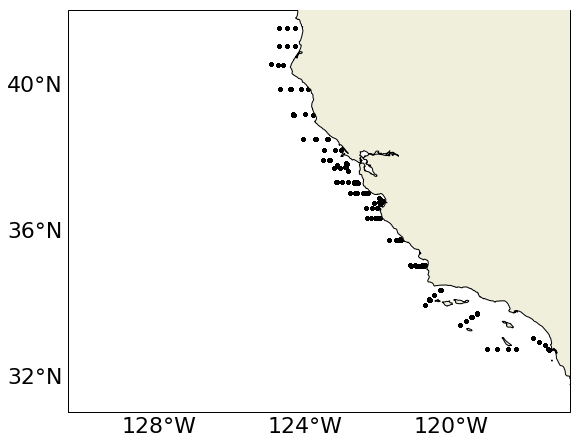

In [4]:
rf_2015 = rf_df[rf_df.index > dt.datetime(2015,1,1)]
fig, ax = make_map()
ax.scatter(rf_2015['longitude (degrees_east)'], rf_2015['latitude (degrees_north)'], marker='.',c='k')

## HFR 6-km radar data

In [5]:
hfr_url = "http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd"
hfr_ds = xr.open_dataset(hfr_url)
recent_ds = hfr_ds.isel(time=-2)
u = recent_ds['u']
v = recent_ds['v']
speed = np.sqrt(u.values**2 + v.values**2)
xx,yy = np.meshgrid(recent_ds['lon'], recent_ds['lat'])

In [6]:
%matplotlib inline

In [7]:
ix = np.where(speed < .5)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


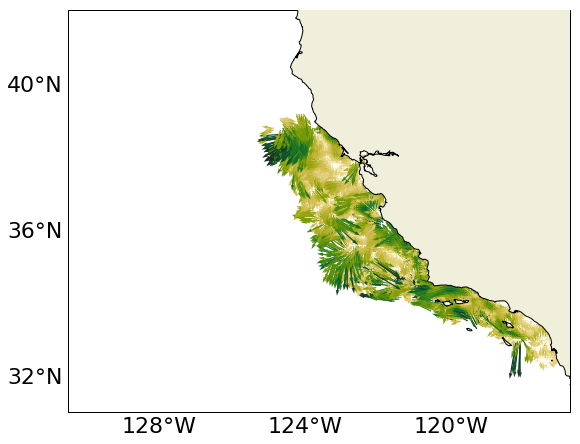

In [8]:
fig, ax = make_map()
ax.quiver(xx[ix],yy[ix],u.values[ix],v.values[ix],speed[ix],
          cmap=cm.speed,
          scale_units='xy',
          scale=.5,)
# ax.scatter(rf_2015['longitude (degrees_east)'], rf_2015['latitude (degrees_north)'], marker='.',c='k')

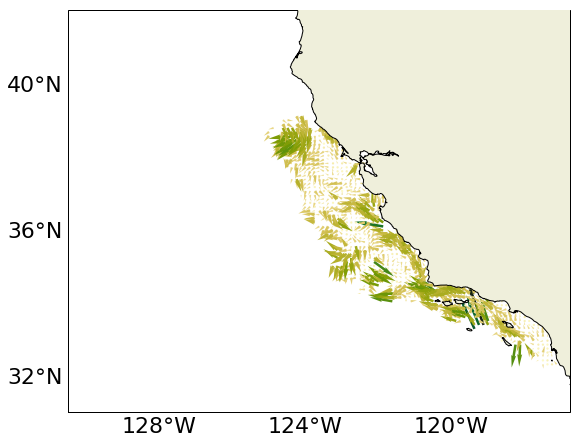

In [9]:
fig, ax = make_map()
ax.quiver(xx[::2,::2],yy[::2,::2],u[::2,::2],v[::2,::2],speed[::2,::2],
          cmap=cm.speed,
          scale_units='xy',
          scale=.75,
         width=.005,
         headwidth=2)
# ax.scatter(rf_2015['longitude (degrees_east)'], rf_2015['latitude (degrees_north)'], marker='.',c='k')

## Get Glider lines

In [12]:
e = ERDDAP(
    server='https://data.ioos.us/gliders/erddap',
    protocol='tabledap',
)
min_lon,max_lon,min_lat,max_lat= (-130,-116.75,32,42)
min_time = "2018-01-01T00:00:00Z"
max_time = "2019-01-01T00:00:00Z"
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': min_lon,
    'max_lon': max_lon,
    'min_lat': min_lat,
    'max_lat': max_lat,
    'min_time': min_time,
    'max_time': max_time,
    'cdm_data_type': 'trajectoryprofile'
}
search_url = e.get_search_url(response='csv', **kw)
search = pd.read_csv(search_url)
gliders = search['Dataset ID'].values

In [13]:
e.variables = variables
variables = [
 'latitude',
 'longitude',
 'time',
]

for i, glider_id in enumerate(gliders):
    e.dataset_id = glider_id
    df = e.to_pandas(
        index_col='time (UTC)',
        parse_dates=True,
    ).dropna()
    df['glider_name'] = dataset_id
    print("Pulling glider: {0}".format(glider_id))
    if i == 0:
        df_gliders = df
    else:
        df_array = (df_gliders, df)
        df_gliders = pd.concat(df_array)

Pulling glider: Nemesis-20171115T0000
Pulling glider: Nemesis-20180515T0000
Pulling glider: Nemesis-20180830T0000
Pulling glider: sp011-20171113T1837
Pulling glider: sp013-20180927T1717
Pulling glider: sp014-20180301T1819
Pulling glider: sp025-20171012T1654
Pulling glider: sp025-20180430T1727
Pulling glider: sp030-20171011T1719
Pulling glider: sp030-20180508T1653
Pulling glider: sp034-20180514T1938
Pulling glider: sp039-20170620T1714
Pulling glider: sp039-20180816T1934
Pulling glider: sp040-20180117T2223
Pulling glider: sp040-20180816T1936
Pulling glider: sp041-20180301T1817
Pulling glider: sp041-20180927T1721
Pulling glider: sp047-20180508T1650
Pulling glider: sp047-20180621T1608
Pulling glider: sp052-20180117T2226
Pulling glider: sp054-20171011T1721
Pulling glider: sp055-20180619T1736
Pulling glider: sp058-20180126T1753
Pulling glider: sp058-20180823T1614
Pulling glider: sp064-20171113T1842
Pulling glider: sp064-20180619T1733
Pulling glider: sp064-20180823T1615
Pulling glider: unit71

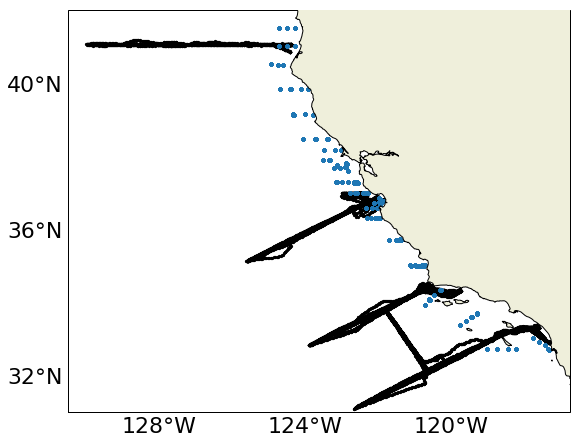

In [14]:
fig, ax = make_map()
# ax.quiver(xx,yy,u,v,speed,cmap=cm.speed,units='x',scale=3,scale_units='x') # HFR
ax.scatter(df_gliders['longitude (degrees_east)'], df_gliders['latitude (degrees_north)'],s=20,marker='.',c='k') # Gliders
ax.scatter(rf_2015['longitude (degrees_east)'], rf_2015['latitude (degrees_north)'], marker='.') # Rockfish


### Add ATN Tracks

In [15]:

e = ERDDAP(
    server='https://coastwatch.pfeg.noaa.gov/erddap',
    protocol='tabledap',
)
e.dataset_id = "gtoppAT"

# e.constraints = {
#     'latitude>=': min_lat,
#     'latitude<=': max_lat,
#     'longitude>=': 360 + min_lon,
#     'longitude<=': 360 + max_lon,
# }

e.variables = [
 'time',
 'latitude',
 'longitude',
 'toppID',
 'commonName',
 'yearDeployed',
 'isDrifter'
]

atn_df = e.to_pandas().dropna()

print(atn_df['commonName'].unique())
atn_df['longitude (degrees_east)'] = -360+atn_df['longitude (degrees_east)']

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


['Atlantic Sailfish' 'Basking Shark' 'Black Marlin'
 'Black-footed Albatross' 'Blue Marlin' 'Blue Shark' 'Blue Whale'
 'California Sea Lion' 'Common Thresher Shark' 'Crabeater Seal'
 'Devil Ray' 'Dolphin-fish' 'Fin Whale' 'Galapagos Sea Lion'
 'Galapagos Shark' 'Greenland Shark' 'Grey Reef Shark' 'Hawksbill Turtle'
 'Humboldt Squid' 'Humpback Whale' 'Juvenile White Shark'
 'Laysan Albatross' 'Leatherback Sea Turtle' 'Loggerhead Sea Turtle'
 'Manta Ray' 'Mediterranean Spearfish' 'Northern Elephant Seal'
 'Northern Fur Seal' 'Ocean Sunfish' 'Oceanic Whitetip Shark'
 'Pacific Sailfish' 'Porbeagle Shark' 'Salmon Shark' 'Sandtiger Shark'
 'Shortbill Spearfish' 'Shortfin Mako Shark' 'Silky Shark'
 'Silvertip Shark' 'Smooth Hammerhead' 'Sooty Shearwater'
 'South American Sea Lion' 'Southern Elephant Seal' 'Sperm Whale'
 'Striped Marlin' 'Swordfish' 'Tiger Shark' 'Weddell Seal' 'Whale Shark'
 'White Marlin' 'White Shark' 'Yellowfin Tuna']


In [16]:
def plot_seal_tracks(ax, atn_df):
    """ Plot the atn elephan seal tracks deployed after 2016"""
    elph_seals = atn_df[(atn_df['commonName'] == "Northern Elephant Seal")&(atn_df['yearDeployed'] >= 2016)]
    for t_id in elph_seals['toppID'].unique():
        tag = elph_seals[(elph_seals['toppID'] == t_id)]
        ax.scatter(tag['longitude (degrees_east)'], tag['latitude (degrees_north)'], s=22,marker="o",edgecolor='.25',)
    

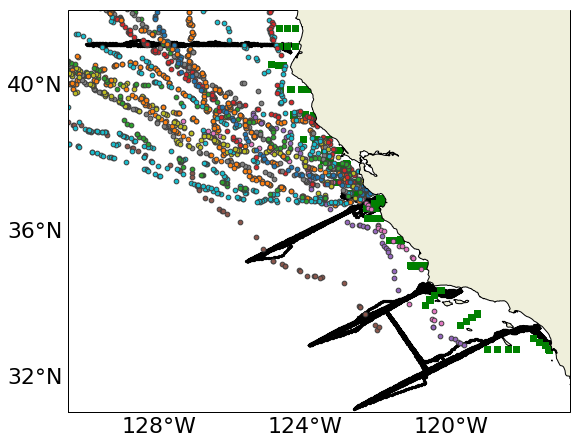

In [17]:
fig, ax = make_map()
ax.scatter(df_gliders['longitude (degrees_east)'], df_gliders['latitude (degrees_north)'],s=20,marker='.',c='k') # Gliders
ax.scatter(rf_2015['longitude (degrees_east)'], rf_2015['latitude (degrees_north)'], marker="s",c='g') # Rockfish
plot_seal_tracks(ax, atn_df)
# fname = os.path.join('MBON_all_map.png')
# plt.savefig(fname, dpi = 300, bbox_inches='tight', pad_inches=.5)

### SST Data

In [18]:
# ghrsst_NAVO-L4HR1m-GLOB-K10_SST
url="https://thredds.jpl.nasa.gov/thredds/dodsC/ncml_aggregation/OceanTemperature/ghrsst/aggregate__ghrsst_NAVO-L4HR1m-GLOB-K10_SST.ncml"
sst_ds = xr.open_dataset(url)
sst_recent = sst_ds.sel(time=slice(dt.datetime(2018,5,1),dt.datetime(2018,6,1)), lat=slice(42, 31), lon=slice(-130.5,-116.75)) #extent=(-130.5,-116.75,31,42))
xx,yy = np.meshgrid(sst_recent['lon'], sst_recent['lat'])

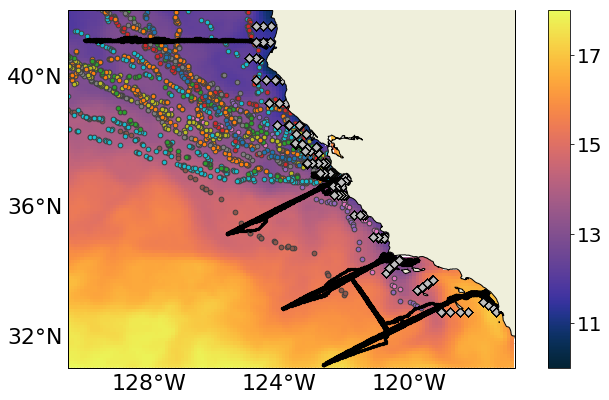

In [19]:
fig, ax = make_map()
im = ax.pcolormesh(xx, yy, sst_recent['analysed_sst'].mean(dim='time')-273.15, cmap=cm.thermal, vmin=10, vmax=18)
plot_seal_tracks(ax, atn_df)
ax.scatter(df_gliders['longitude (degrees_east)'], df_gliders['latitude (degrees_north)'],s=20,marker='.',c='k') # Gliders
ax.scatter(rf_2015['longitude (degrees_east)'], rf_2015['latitude (degrees_north)'],marker="D",edgecolor='k',c='.75') # Rockfish

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=.45, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cbar = plt.colorbar(im, cax=ax_cb,ticks=range(9,21,2))
cbar.ax.tick_params(labelsize=20) 
 
fname = os.path.join('MBON_sst_map.png')
# plt.savefig(fname, dpi = 300, bbox_inches='tight', pad_inches=.5)

## Georeference seascape raster

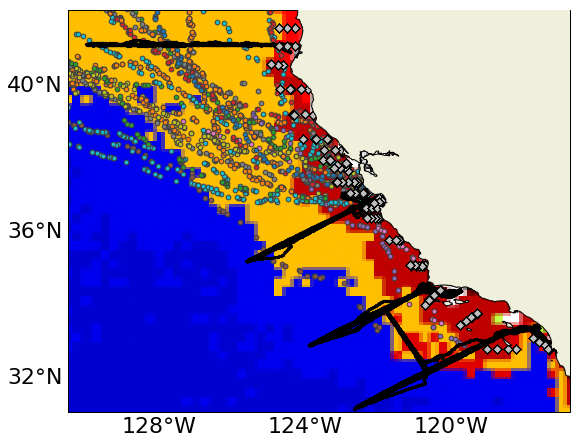

In [29]:
fig, ax = make_map()

img_extent = [-135, -90, 0, 60]
fname = "./MAY_CCS_seascape.jpg"

img = plt.imread(fname)
ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())
plot_seal_tracks(ax, atn_df)
ax.scatter(df_gliders['longitude (degrees_east)'], df_gliders['latitude (degrees_north)'],s=20,marker='.',c='k') # Gliders
ax.scatter(rf_2015['longitude (degrees_east)'], rf_2015['latitude (degrees_north)'],marker="D",edgecolor='k',c='.75') # Rockfish


fname = os.path.join('MBON_seascape_map.png')
plt.savefig(fname, dpi = 300, bbox_inches='tight', pad_inches=.5)

### Make Panel Maps

In [ ]:
# Mapping helper function
def make_map_panel(projection=ccrs.PlateCarree(),extent=(-130.5,-116.75,31,42),n=4,sharex=True):
    fig, ax = plt.subplots(nrows=2,ncols=2,
        subplot_kw={'projection': projection}
    )
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.05, hspace=.05)
    fig.set_size_inches(7,6)

    for i, ax_i in enumerate(ax.flatten()):
        ax_i.set_extent(extent, crs=ccrs.PlateCarree())
        gl = ax_i.gridlines(draw_labels=True,)
        gl.xlines = False
        gl.ylines = False
        gl.ylabels_right = False
        ax_i.coastlines('50m')
        ocean_50m  = cfeature.NaturalEarthFeature(category='physical', name='ocean',
                                scale='50m', facecolor=cfeature.COLORS['water'])
        ax_i.add_feature(ocean_50m,zorder=0)
        plt.xticks(rotation='vertical')
        gl.xlocator = mticker.FixedLocator(np.arange(-129,-117,3))
        gl.ylocator = mticker.FixedLocator(np.arange(32,42,3))
#         gl.xformatter = LONGITUDE_FORMATTER
#         gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16}
        gl.ylabel_style = {'size': 16}
        if i == 0:
            gl.xlabels_bottom= False
            gl.xlabels_top= False
        elif i == 1:
            gl.ylabels_left = False
            gl.xlabels_bottom= False
            gl.xlabels_top= False
        elif i == 2:
            gl.ylabels_right= False
            gl.xlabels_top= False
        else:
            gl.ylabels_left= False
            gl.ylabels_right= False
            gl.xlabels_top= False

    return fig, ax.flatten()

# fig, ax = make_map_panel()

In [ ]:
fig, ax = make_map_panel()
ax[0].quiver(xx[ix],yy[ix],u.values[ix],v.values[ix],speed[ix],
          cmap=cm.speed,
          scale_units='xy',
          scale=.75) # HFR
ax[1].scatter(df_gliders['longitude (degrees_east)'], df_gliders['latitude (degrees_north)'],s=5,marker='.',c='k') # Gliders
ax[2].scatter(rf_2015['longitude (degrees_east)'], rf_2015['latitude (degrees_north)'], marker=".",c='k',s=3) # Rockfish
plot_seal_tracks(ax[3], atn_df)

fname = os.path.join('MBON_panel_map.png')
plt.savefig(fname, dpi = 300, bbox_inches='tight', pad_inches=.5)

In [ ]:
import folium
from folium.plugins import Fullscreen, MarkerCluster

m = folium.Map(location=[37.5, -122], tiles='OpenStreetMap', zoom_start=4)

Fullscreen(position='topright', force_separate_button=True).add_to(m)

marker_cluster0 = MarkerCluster(name='Observations')
marker_cluster0.add_to(m);

In [ ]:
# url = 'http://oos.soest.hawaii.edu/thredds/wms/hioos/satellite/dhw_5km'
# w0 = folium.WmsTileLayer(
#     url,
#     name='Sea Surface Temperature',
#     fmt='image/png',
#     layers='CRW_SST',
#     attr='PacIOOS TDS',
#     overlay=True,
#     transparent=True)

url = 'http://hfrnet.ucsd.edu/thredds/wms/HFRNet/USEGC/6km/hourly/RTV'
w1 = folium.WmsTileLayer(
    url,
    name='HF Radar',
    fmt='image/png',
    layers='surface_sea_water_velocity',
    attr='HFRNet',
    overlay=True,
    transparent=True)

# w0.add_to(m)
w1.add_to(m);

In [ ]:
def embed_map(m):
    from IPython.display import HTML

    m.save('index.html')
    with open('index.html') as f:
        html = f.read()

    srcdoc = html.replace('"', '&quot;')
    iframe = f'<iframe srcdoc="{srcdoc}" style="width: 100%; height: 750px; border: none"></iframe>'
    return HTML(iframe)